Which Incoterm tends to minimize total cost for each region?

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

DATA_PATH = Path().cwd().parent / "data"


def read_data(file_name):
    return pd.read_csv(DATA_PATH / file_name, parse_dates=True)


shipments_df = read_data("shipments.csv")
po_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
skus_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")
_datetime_map = {
    "shipments": (shipments_df, ["ship_date", "eta_date", "actual_delivery_date"]),
    "purchase_orders": (po_df, ["order_date", "promised_date"]),
    "transit_events": (transit_events_df, ["event_ts"]),
}
for _, (df, cols) in _datetime_map.items():
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

shipments_df

,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status
0,SH-00000001,PO-0104861,6,Road,CIF,Mexico,ST-00452,2025-02-03,2025-02-10,Delivered
1,SH-00000002,PO-0099598,3,Sea,EXW,India,ST-00086,2024-08-21,2024-09-27,Delayed
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit
4,SH-00000005,PO-0003236,6,Road,DAP,Brazil,ST-01995,2025-06-19,2025-06-27,Delivered
...,...,...,...,...,...,...,...,...,...,...
217495,SH-00217496,PO-0033886,2,Road,EXW,Argentina,ST-01757,2023-09-30,2023-10-07,In Transit
217496,SH-00217497,PO-0038120,7,Road,EXW,Mexico,ST-01876,2024-08-14,2024-08-27,Delivered
217497,SH-00217498,PO-0079713,3,Air,DAP,Spain,ST-01330,2023-12-25,2024-01-02,In Transit
217498,SH-00217499,PO-0044911,4,Air,FOB,Brazil,ST-01986,2025-02-24,2025-03-05,Delivered


In [2]:
shipments_df["incoterm"].value_counts()

incoterm
FOB    54586
DAP    54454
CIF    43488
DDP    32639
EXW    32333
Name: count, dtype: int64

In [3]:
# merge by po_df.po_id = shipments_df.po_id

# shipment → po_id
# po → sku_id + unit_price_usd
# sku → weight/volume
# site → region

merged_df = shipments_df.merge(
    po_df[["po_id", "region", "sku_id", "unit_price_usd"]],
    on="po_id",
    how="left",
)

merged_df = merged_df.merge(
    skus_df[["sku_id", "unit_weight_kg", "unit_volume_m3", "std_cost_usd"]],
    on="sku_id",
    how="left",
)
display(merged_df.head())

,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,region,sku_id,unit_price_usd,unit_weight_kg,unit_volume_m3,std_cost_usd
0,SH-00000001,PO-0104861,6,Road,CIF,Mexico,ST-00452,2025-02-03,2025-02-10,Delivered,APAC,SKU-01340,254.94,9.86,0.1112,251.64
1,SH-00000002,PO-0099598,3,Sea,EXW,India,ST-00086,2024-08-21,2024-09-27,Delayed,APAC,SKU-00367,180.57,22.27,0.2260,169.04
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit,EMEA,SKU-04080,606.62,30.12,0.3110,536.85
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit,EMEA,SKU-01344,345.47,12.38,0.1376,328.45
4,SH-00000005,PO-0003236,6,Road,DAP,Brazil,ST-01995,2025-06-19,2025-06-27,Delivered,EMEA,SKU-04394,1083.48,7.68,0.0868,979.73



- EXW → Ty płacisz wszystko
- FOB → vendor płaci za handling origin, Ty resztę
- CIF → vendor płaci freight + insurance origin → Ty płacisz tylko duty/last mile

In [4]:
# IMPORTANT!!!! We will assume:
# Insurance cost = 1% of unit price
# Duty cost = 5% of unit price
# Handling (flat) = $50
# Freight rate per kg: Road = 0.8 USD/kg, Sea = 0.15 USD/kg, Air = 1.5 USD/kg

from cv2 import merge


merged_df["handling_cost"] = 50.0
merged_df["freight_cost"] = np.where(
    merged_df["mode"] == "Road",
    0.8 * merged_df["unit_weight_kg"],
    np.where(
        merged_df["mode"] == "Sea",
        0.15 * merged_df["unit_weight_kg"],
        np.where(merged_df["mode"] == "Air", 1.5 * merged_df["unit_weight_kg"], 0),
    ),
) 

# cargo_value = unit_price_usd * ship_qty
merged_df["cargo_value"] = (
    merged_df["unit_price_usd"] * merged_df["ship_qty"]
)   
merged_df["weight_total"] = (
    merged_df["unit_weight_kg"] * merged_df["ship_qty"]
)
merged_df["incurance_cost"] = 0.01 * merged_df["cargo_value"]
merged_df["duty_cost"] = 0.05 * merged_df["cargo_value"]
merged_df

ModuleNotFoundError: No module named 'cv2'

| Incoterm | Seller Pays | Buyer Pays | Total Cost for Buyer |
|----------|-------------|------------|---------------------|
| **EXW** (Ex Works) | Nothing | Freight + Insurance + Duty + Handling | freight + insurance + duty + handling |
| **FOB** (Free On Board) | Handling at origin | Freight + Insurance + Duty | freight + insurance + duty |
| **CIF** (Cost, Insurance & Freight) | Freight + Insurance | Duty + Handling | duty + handling |
| **DAP** (Delivered At Place) | Freight + Handling (typically) | Duty (+ possible minor handling) | duty (or duty + minor_handling) |
| **DDP** (Delivered Duty Paid) | Everything (all costs) | Nothing | 0 (product price includes all costs) |

In [ ]:
merged_df["total_cost_by_incoterm"] = np.select(
    [
        merged_df["incoterm"] == "EXW",
        merged_df["incoterm"] == "FOB",
        merged_df["incoterm"] == "CIF",
        merged_df["incoterm"] == "DAP",
        merged_df["incoterm"] == "DDP",
    ],
    [
        # EXW: product + freight + insurance + duty + handling
        merged_df["cargo_value"] + merged_df["freight_cost"] + merged_df["incurance_cost"] + merged_df["duty_cost"] + merged_df["handling_cost"],
        # FOB: product + freight + insurance + duty
        merged_df["cargo_value"] + merged_df["freight_cost"] + merged_df["incurance_cost"] + merged_df["duty_cost"],
        # CIF: product + duty + handling
        merged_df["cargo_value"] + merged_df["duty_cost"] + merged_df["handling_cost"],
        # DAP: product + duty
        merged_df["cargo_value"] + merged_df["duty_cost"],
        # DDP: product (vendor paid all logistics already included in price)
        merged_df["cargo_value"],
    ],
    default=np.nan
)

display(merged_df[["incoterm", "cargo_value", "freight_cost", "incurance_cost", "duty_cost", "handling_cost", "total_cost_by_incoterm"]])


,incoterm,cargo_value,freight_cost,incurance_cost,duty_cost,handling_cost,total_cost_by_incoterm
0,CIF,1529.64,7.8880,15.2964,76.4820,50.0,1656.1220
1,EXW,541.71,3.3405,5.4171,27.0855,50.0,627.5531
2,FOB,4852.96,24.0960,48.5296,242.6480,50.0,5168.2336
3,FOB,2072.82,1.8570,20.7282,103.6410,50.0,2199.0462
4,DAP,6500.88,6.1440,65.0088,325.0440,50.0,6825.9240
...,...,...,...,...,...,...,...
217495,EXW,1204.48,25.4400,12.0448,60.2240,50.0,1352.1888
217496,EXW,1160.04,12.8640,11.6004,58.0020,50.0,1292.5064
217497,DAP,2463.45,46.7100,24.6345,123.1725,50.0,2586.6225
217498,FOB,1461.28,63.7950,14.6128,73.0640,50.0,1612.7518


In [ ]:
# Group by region and incoterm, calculate cost metrics
merged_df["cost_per_unit"] = merged_df["total_cost_by_incoterm"] / merged_df["ship_qty"]

groupby_analysis = merged_df.groupby(["region", "incoterm"]).agg({
    "total_cost_by_incoterm": ["mean", "median", "std", "min", "max", "count"],
    "cost_per_unit": "mean"
}).round(2)

groupby_analysis.columns = ["_".join(col).strip() for col in groupby_analysis.columns.values]
groupby_analysis = groupby_analysis.rename(columns={
    "total_cost_by_incoterm_mean": "avg_total_cost",
    "total_cost_by_incoterm_median": "median_total_cost",
    "total_cost_by_incoterm_std": "std_total_cost",
    "total_cost_by_incoterm_min": "min_total_cost",
    "total_cost_by_incoterm_max": "max_total_cost",
    "total_cost_by_incoterm_count": "shipment_count",
    "cost_per_unit_mean": "avg_cost_per_unit"
})

print("=== Incoterm Cost Analysis by Region ===\n")
display(groupby_analysis)

# Reset index for easier manipulation
groupby_df = groupby_analysis.reset_index()


=== Incoterm Cost Analysis by Region ===



avg_total_cost  median_total_cost  std_total_cost  \
region incoterm                                                      
AMER   CIF              3069.35            2072.71         3303.23   
       DAP              3095.19            2061.11         3494.15   
       DDP              2962.85            1939.98         3423.57   
       EXW              3163.74            2099.19         3408.85   
       FOB              3109.06            2053.10         3515.02   
APAC   CIF              3090.64            2080.73         3605.13   
       DAP              3010.88            1976.47         3455.03   
       DDP              2808.12            1855.70         3086.62   
       EXW              3136.66            2120.27         3416.95   
       FOB              3058.88            2011.68         3549.03   
EMEA   CIF              3049.48            2003.54         3431.64   
       DAP              3044.06            1996.88         3456.52   
       DDP              2908.48            1906.16         3333.91   
       EXW              3144.84            2106.73         3483.03   
       FOB              3057.21            2014.31         3340.41   

                 min_total_cost  max_total_cost  shipment_count  \
region incoterm                                                   
AMER   CIF               119.62        58675.53            8632   
       DAP                40.15        52067.61           11061   
       DDP                67.23        47363.40            6595   
       EXW                91.84        43197.14            6458   
       FOB                53.98        72332.81           10889   
APAC   CIF                99.44        95026.80            8812   
       DAP                20.08        67119.59           10993   
       DDP                42.39        67100.67            6547   
       EXW                98.32        40614.74            6455   
       FOB                29.83        58706.46           10940   
EMEA   CIF                89.40        81620.03           26044   
       DAP                39.74        79842.17           32400   
       DDP                40.76        62145.20           19497   
       EXW                90.23        59778.47           19420   
       FOB                42.22        63073.91           32757   

                 avg_cost_per_unit  
region incoterm                     
AMER   CIF                  617.52  
       DAP                  609.39  
       DDP                  584.69  
       EXW                  635.89  
       FOB                  624.56  
APAC   CIF                  619.78  
       DAP                  606.26  
       DDP                  561.56  
       EXW                  626.44  
       FOB                  606.16  
EMEA   CIF                  612.31  
       DAP                  605.93  
       DDP                  578.84  
       EXW                  630.75  
       FOB                  613.98

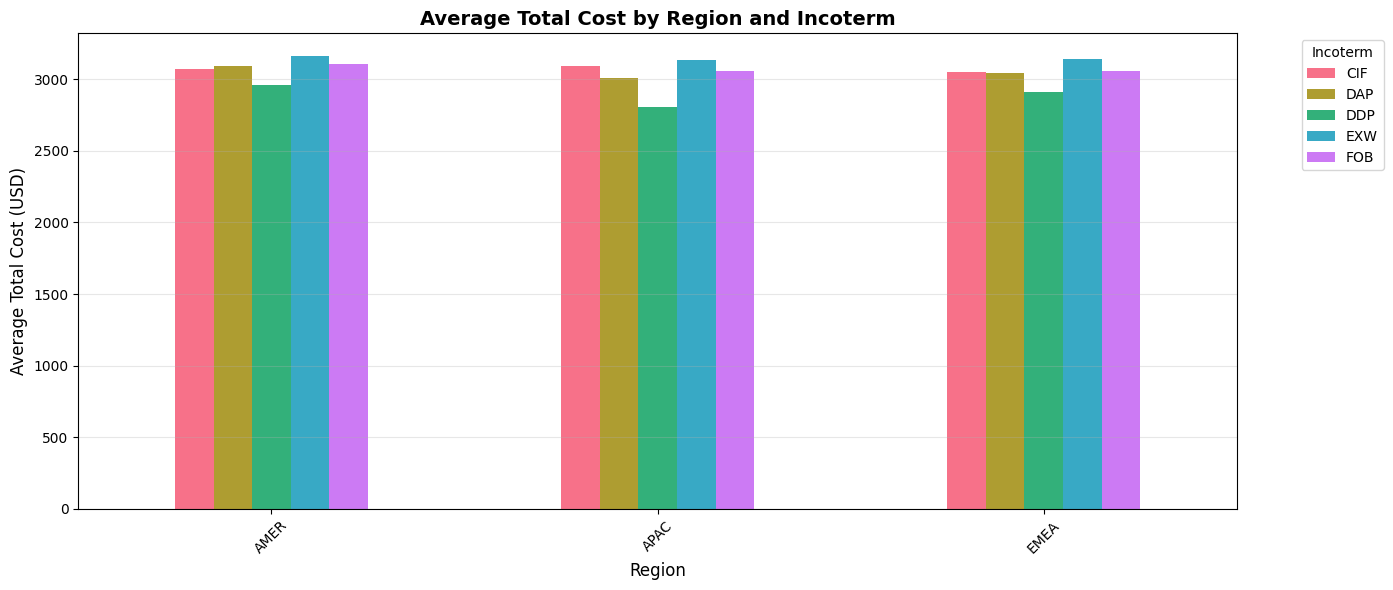

In [ ]:
# Visualization 1: Average Total Cost by Region and Incoterm
fig, ax = plt.subplots(figsize=(14, 6))
pivot_avg = groupby_df.pivot(index="region", columns="incoterm", values="avg_total_cost")
pivot_avg.plot(kind="bar", ax=ax, color=sns.color_palette("husl", len(pivot_avg.columns)))
ax.set_title("Average Total Cost by Region and Incoterm", fontsize=14, fontweight="bold")
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Average Total Cost (USD)", fontsize=12)
ax.legend(title="Incoterm", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(axis="y", alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# IMPORTANT
I have suspicion that Shipments cost are not included in the unit_price per product, so from data we can assume that Incoterm DDP is the most cost effective for us. but I don't believe it.

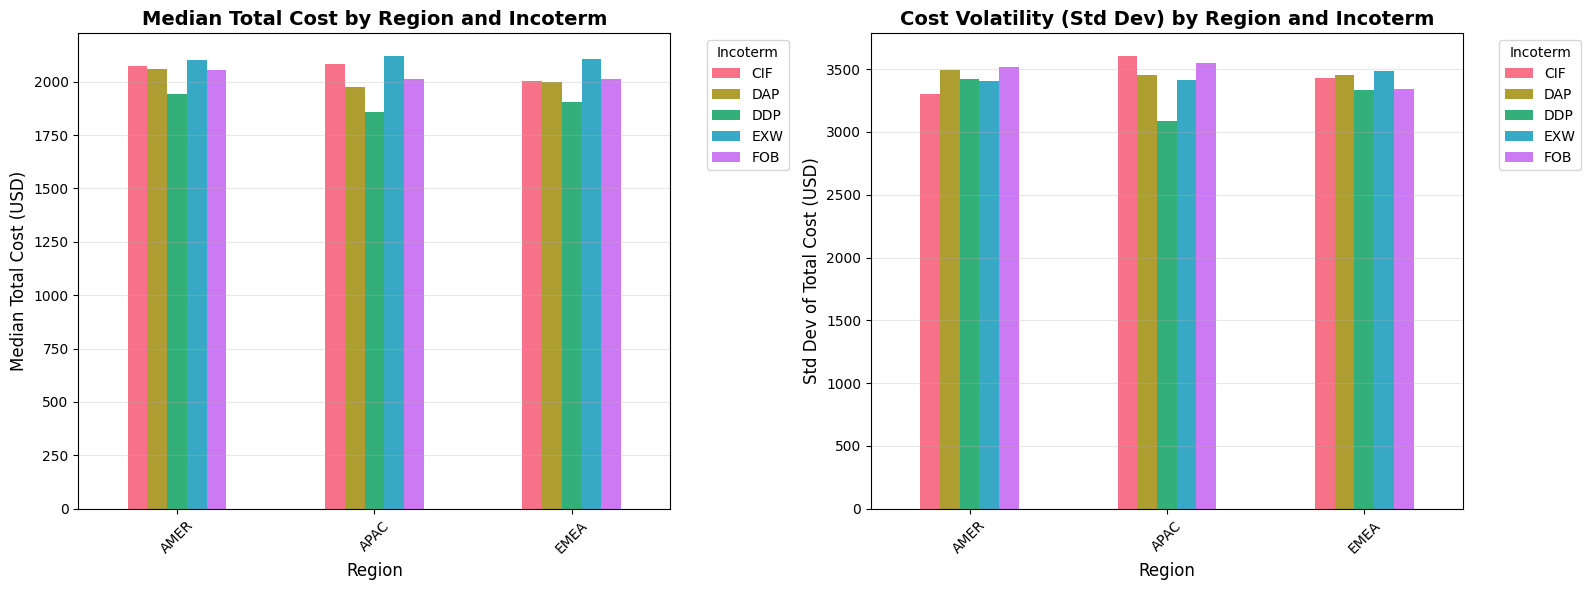

In [ ]:
# Visualization 2: Median vs Std (Risk/Volatility) by Incoterm
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Median comparison
pivot_median = groupby_df.pivot(index="region", columns="incoterm", values="median_total_cost")
pivot_median.plot(kind="bar", ax=ax1, color=sns.color_palette("husl", len(pivot_median.columns)))
ax1.set_title("Median Total Cost by Region and Incoterm", fontsize=14, fontweight="bold")
ax1.set_xlabel("Region", fontsize=12)
ax1.set_ylabel("Median Total Cost (USD)", fontsize=12)
ax1.legend(title="Incoterm", bbox_to_anchor=(1.05, 1), loc="upper left")
ax1.grid(axis="y", alpha=0.3)
ax1.tick_params(axis="x", rotation=45)

# Std (risk) comparison
pivot_std = groupby_df.pivot(index="region", columns="incoterm", values="std_total_cost")
pivot_std.plot(kind="bar", ax=ax2, color=sns.color_palette("husl", len(pivot_std.columns)))
ax2.set_title("Cost Volatility (Std Dev) by Region and Incoterm", fontsize=14, fontweight="bold")
ax2.set_xlabel("Region", fontsize=12)
ax2.set_ylabel("Std Dev of Total Cost (USD)", fontsize=12)
ax2.legend(title="Incoterm", bbox_to_anchor=(1.05, 1), loc="upper left")
ax2.grid(axis="y", alpha=0.3)
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


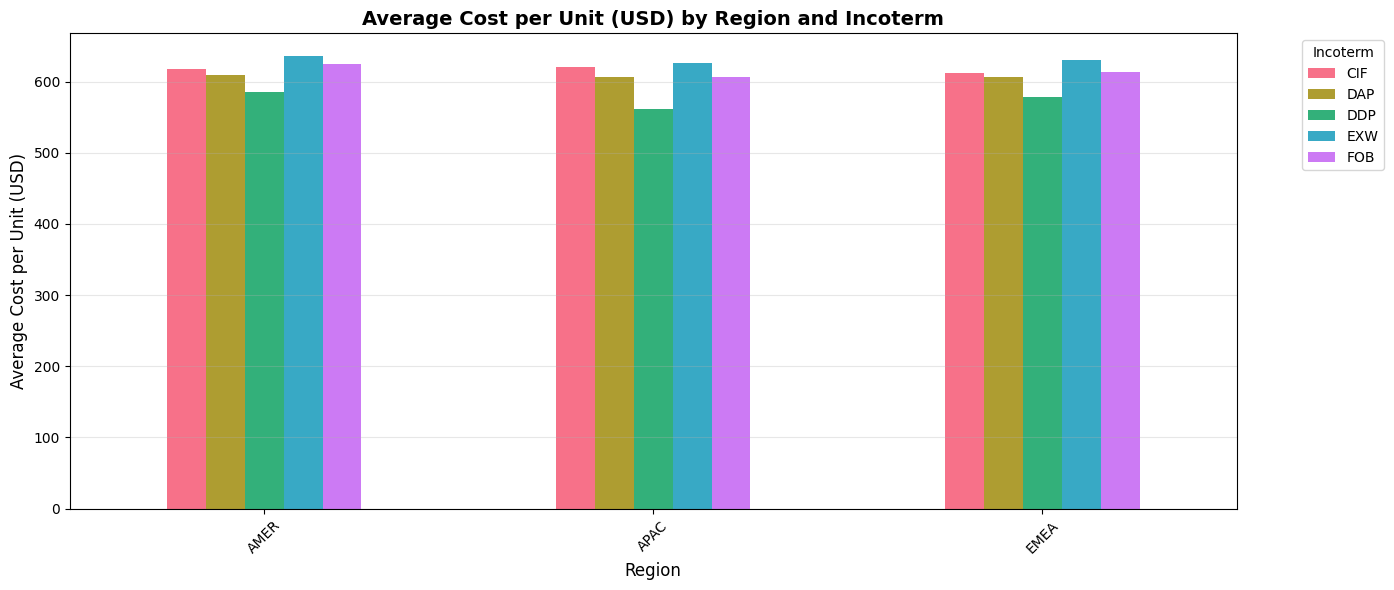

In [ ]:
# Visualization 3: Cost per Unit by Region and Incoterm
fig, ax = plt.subplots(figsize=(14, 6))
pivot_cost_per_unit = groupby_df.pivot(index="region", columns="incoterm", values="avg_cost_per_unit")
pivot_cost_per_unit.plot(kind="bar", ax=ax, color=sns.color_palette("husl", len(pivot_cost_per_unit.columns)))
ax.set_title("Average Cost per Unit (USD) by Region and Incoterm", fontsize=14, fontweight="bold")
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Average Cost per Unit (USD)", fontsize=12)
ax.legend(title="Incoterm", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(axis="y", alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


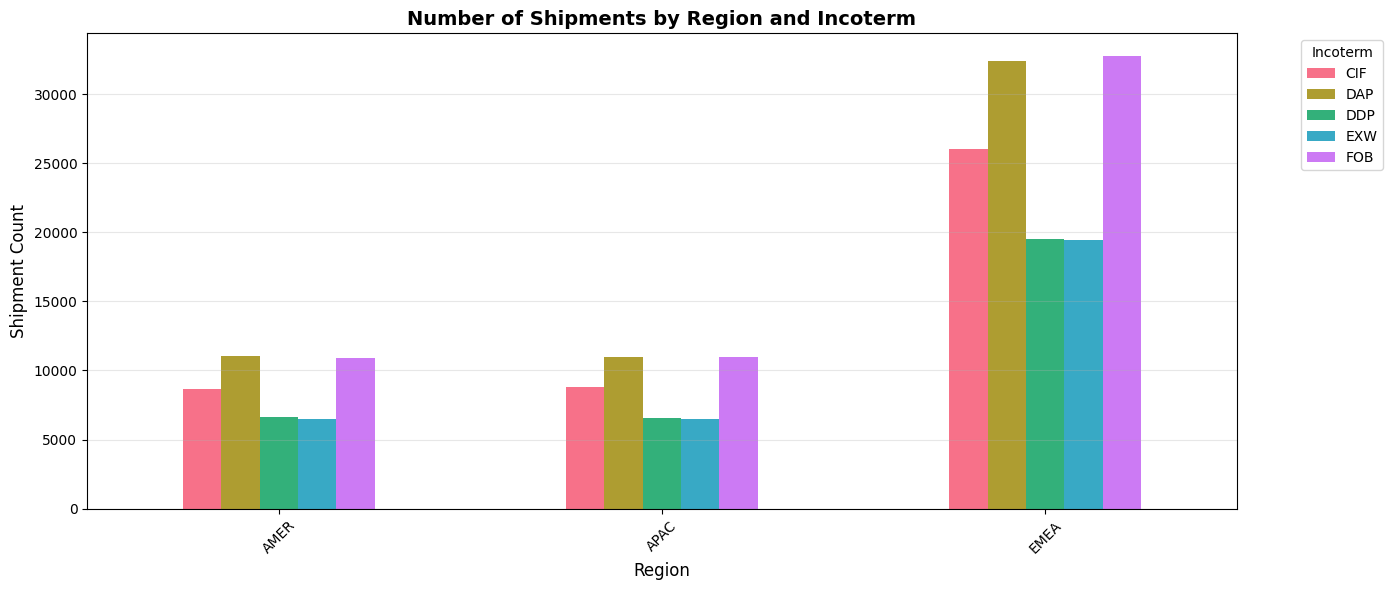

In [ ]:
# Visualization 4: Shipment Count (Data Reliability) by Region and Incoterm
fig, ax = plt.subplots(figsize=(14, 6))
pivot_count = groupby_df.pivot(index="region", columns="incoterm", values="shipment_count")
pivot_count.plot(kind="bar", ax=ax, color=sns.color_palette("husl", len(pivot_count.columns)))
ax.set_title("Number of Shipments by Region and Incoterm", fontsize=14, fontweight="bold")
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Shipment Count", fontsize=12)
ax.legend(title="Incoterm", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(axis="y", alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\miskibin\AppData\Local\Temp\ipykernel_29172\116338407.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="incoterm", y="total_cost_by_incoterm", order=incoterm_order, ax=ax, palette="husl")


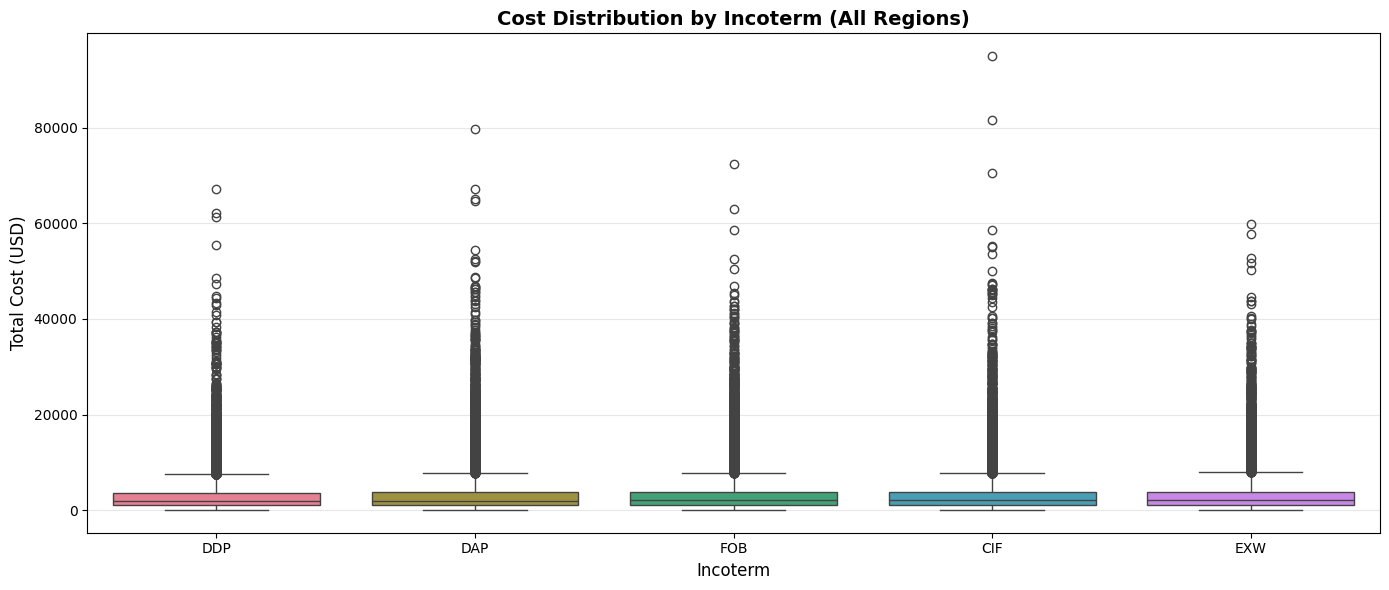


Incoterm ranking by median cost (cheapest first):
1. DDP: $1902.27
2. DAP: $2004.68
3. FOB: $2021.01
4. CIF: $2032.74
5. EXW: $2106.19


In [ ]:
# Visualization 5: Box plot - Distribution of costs by Incoterm (all regions combined)
fig, ax = plt.subplots(figsize=(14, 6))
incoterm_order = merged_df.groupby("incoterm")["total_cost_by_incoterm"].median().sort_values().index
sns.boxplot(data=merged_df, x="incoterm", y="total_cost_by_incoterm", order=incoterm_order, ax=ax, palette="husl")
ax.set_title("Cost Distribution by Incoterm (All Regions)", fontsize=14, fontweight="bold")
ax.set_xlabel("Incoterm", fontsize=12)
ax.set_ylabel("Total Cost (USD)", fontsize=12)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nIncoterm ranking by median cost (cheapest first):")
for i, inc in enumerate(incoterm_order, 1):
    median_cost = merged_df[merged_df["incoterm"] == inc]["total_cost_by_incoterm"].median()
    print(f"{i}. {inc}: ${median_cost:.2f}")
